# NN03 - Building a Flexible Neural Network from Scratch

*Generalize from a fixed architecture to any number of layers*

---

In [Understanding Neural Networks: From Pixels to Predictions](nn_tutorial_blog.ipynb), we built a 2-layer edge detector with hardcoded weights `W1`, `W2`. But what if we want 3 layers? Or 10?

This tutorial shows how to **generalize** that code into a flexible architecture where you can specify any layer sizes. We'll build a clean `Layer` class that handles forward and backward passes, then stack them together.

**Prerequisites:** You should understand the concepts from the previous tutorial (forward pass, backpropagation, gradient descent).

**Goal:** A ~100-line neural network that can handle arbitrary architectures like `[784, 128, 64, 10]` (for MNIST) or `[25, 8, 2]` (our edge detector).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

---

## The Problem with Hardcoded Layers

In our previous edge detector, we had:

```python
# Hardcoded 2-layer network
W1 = np.random.randn(25, 8) * 0.3
b1 = np.zeros((1, 8))
W2 = np.random.randn(8, 2) * 0.3
b2 = np.zeros((1, 2))
```

And the forward/backward passes explicitly referenced `W1`, `W2`, `z1`, `h1`, etc.

**What if we want 3 layers?** We'd need to add `W3`, `b3`, `z3`, `h3`, and update all the forward/backward code.

**The solution:** Treat each layer as an object that knows how to:
1. **Forward:** Take input, produce output
2. **Backward:** Take gradient from above, compute gradient for weights and pass gradient below


---

## The Layer Class

Each layer stores its own weights and handles its own forward/backward computation.

### Linear Layer (Dense/Fully Connected)

A linear layer computes: $\mathbf{z} = \mathbf{x} W + \mathbf{b}$

- **Forward:** Store input (needed for backward), compute output
- **Backward:** Compute gradients for W and b, return gradient for input


In [2]:
class Linear:
    """Fully connected layer: z = x @ W + b"""
    
    def __init__(self, in_features, out_features):
        # Initialize weights (He initialization for ReLU)
        self.W = np.random.randn(in_features, out_features) * np.sqrt(2.0 / in_features)
        self.b = np.zeros((1, out_features))
        
        # Gradients (computed in backward)
        self.dW = None
        self.db = None
        
        # Cache for backward pass
        self.x = None
    
    def forward(self, x):
        self.x = x  # Cache input for backward
        return x @ self.W + self.b
    
    def backward(self, dz):
        """
        dz: gradient of loss w.r.t. this layer's output (shape: batch × out_features)
        Returns: gradient of loss w.r.t. this layer's input (shape: batch × in_features)
        """
        # Gradient for weights: dL/dW = x.T @ dL/dz
        self.dW = self.x.T @ dz
        
        # Gradient for bias: dL/db = sum over batch
        self.db = np.sum(dz, axis=0, keepdims=True)
        
        # Gradient for input: dL/dx = dL/dz @ W.T
        dx = dz @ self.W.T
        return dx
    
    def update(self, lr):
        """Update weights using gradient descent"""
        self.W -= lr * self.dW
        self.b -= lr * self.db

print("Linear layer: z = x @ W + b")
print("  forward(x)  -> stores x, returns z")
print("  backward(dz) -> computes dW, db, returns dx")

Linear layer: z = x @ W + b
  forward(x)  -> stores x, returns z
  backward(dz) -> computes dW, db, returns dx


### ReLU Activation

ReLU computes: $h = \max(0, z)$

It has no learnable parameters, but still needs to pass gradients through.


In [3]:
class ReLU:
    """ReLU activation: h = max(0, z)"""
    
    def __init__(self):
        self.z = None  # Cache for backward
    
    def forward(self, z):
        self.z = z
        return np.maximum(0, z)
    
    def backward(self, dh):
        """Gradient flows through where z > 0, blocked where z <= 0"""
        return dh * (self.z > 0)
    
    def update(self, lr):
        pass  # No parameters to update

print("ReLU layer: h = max(0, z)")
print("  forward(z)  -> stores z, returns h")
print("  backward(dh) -> returns dh * (z > 0)")

ReLU layer: h = max(0, z)
  forward(z)  -> stores z, returns h
  backward(dh) -> returns dh * (z > 0)


### Softmax + Cross-Entropy Loss

We combine softmax and cross-entropy into one layer because their combined gradient is simple: $\frac{\partial L}{\partial z} = p - y$


In [4]:
class SoftmaxCrossEntropy:
    """Combined softmax + cross-entropy loss"""
    
    def __init__(self):
        self.p = None  # Probabilities
        self.y = None  # True labels
    
    def forward(self, z, y):
        """
        z: raw scores (batch × classes)
        y: one-hot labels (batch × classes)
        Returns: scalar loss
        """
        # Softmax (with numerical stability)
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        self.p = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        self.y = y
        
        # Cross-entropy loss
        loss = -np.sum(y * np.log(self.p + 1e-8)) / len(y)
        return loss
    
    def backward(self):
        """The beautiful simplification: gradient is just (p - y)"""
        return (self.p - self.y) / len(self.y)

print("SoftmaxCrossEntropy layer:")
print("  forward(z, y) -> returns loss")
print("  backward()    -> returns (p - y) / batch_size")

SoftmaxCrossEntropy layer:
  forward(z, y) -> returns loss
  backward()    -> returns (p - y) / batch_size


---

## The Network Class

Now we can stack layers into a network. The key insight: **forward and backward are just loops!**


In [5]:
class Network:
    """A neural network as a stack of layers"""
    
    def __init__(self, layer_sizes):
        """
        layer_sizes: list like [25, 8, 2] for input -> hidden -> output
        """
        self.layers = []
        
        # Create layers: Linear -> ReLU -> Linear -> ReLU -> ... -> Linear
        for i in range(len(layer_sizes) - 1):
            self.layers.append(Linear(layer_sizes[i], layer_sizes[i + 1]))
            # Add ReLU after all but the last linear layer
            if i < len(layer_sizes) - 2:
                self.layers.append(ReLU())
        
        # Loss function (applied separately)
        self.loss_fn = SoftmaxCrossEntropy()
        
        print(f"Created network: {layer_sizes}")
        print(f"  Layers: {[type(l).__name__ for l in self.layers]}")
    
    def forward(self, x):
        """Forward pass through all layers"""
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self):
        """Backward pass through all layers (in reverse)"""
        grad = self.loss_fn.backward()
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update(self, lr):
        """Update all layer weights"""
        for layer in self.layers:
            layer.update(lr)
    
    def train_step(self, x, y, lr):
        """One complete training step"""
        # Forward
        z = self.forward(x)
        loss = self.loss_fn.forward(z, y)
        
        # Backward
        self.backward()
        
        # Update
        self.update(lr)
        
        return loss

# Example: create a 3-layer network
net = Network([25, 16, 8, 2])

Created network: [25, 16, 8, 2]
  Layers: ['Linear', 'ReLU', 'Linear', 'ReLU', 'Linear']


### How It Works

The forward and backward passes are now just loops:

```
Forward:  x → [Linear → ReLU → Linear → ReLU → Linear] → z → Loss
             layer[0] layer[1] layer[2] layer[3] layer[4]

Backward: Loss → [Linear ← ReLU ← Linear ← ReLU ← Linear] ← gradient
                 layer[4] layer[3] layer[2] layer[1] layer[0]
```

Each layer:
1. Caches what it needs during forward
2. Uses that cache to compute gradients during backward
3. Returns the gradient for the layer below


---

## Testing: Edge Detection with Flexible Architecture

Let's verify our flexible network works by training it on the same edge detection task.


In [6]:
# Create training data (same as before)
def make_data(n_samples=100):
    X, y = [], []
    for _ in range(n_samples):
        if np.random.rand() > 0.5:
            # Edge: dark on left, bright on right
            edge_pos = np.random.randint(1, 4)
            patch = np.ones((5, 5)) * 0.1
            patch[:, edge_pos:] = 0.9
            label = [1, 0]
        else:
            # No edge
            if np.random.rand() > 0.5:
                patch = np.ones((5, 5)) * np.random.uniform(0.3, 0.7)
            else:
                patch = np.ones((5, 5)) * 0.9
                patch[:, 2:] = 0.1
            label = [0, 1]
        X.append(patch.flatten())
        y.append(label)
    return np.array(X), np.array(y)

X_train, y_train = make_data(200)
X_test, y_test = make_data(50)
print(f"Training: {len(X_train)} samples, Test: {len(X_test)} samples")

Training: 200 samples, Test: 50 samples


Created network: [25, 2]
  Layers: ['Linear']
Created network: [25, 8, 2]
  Layers: ['Linear', 'ReLU', 'Linear']


Created network: [25, 16, 8, 2]
  Layers: ['Linear', 'ReLU', 'Linear', 'ReLU', 'Linear']


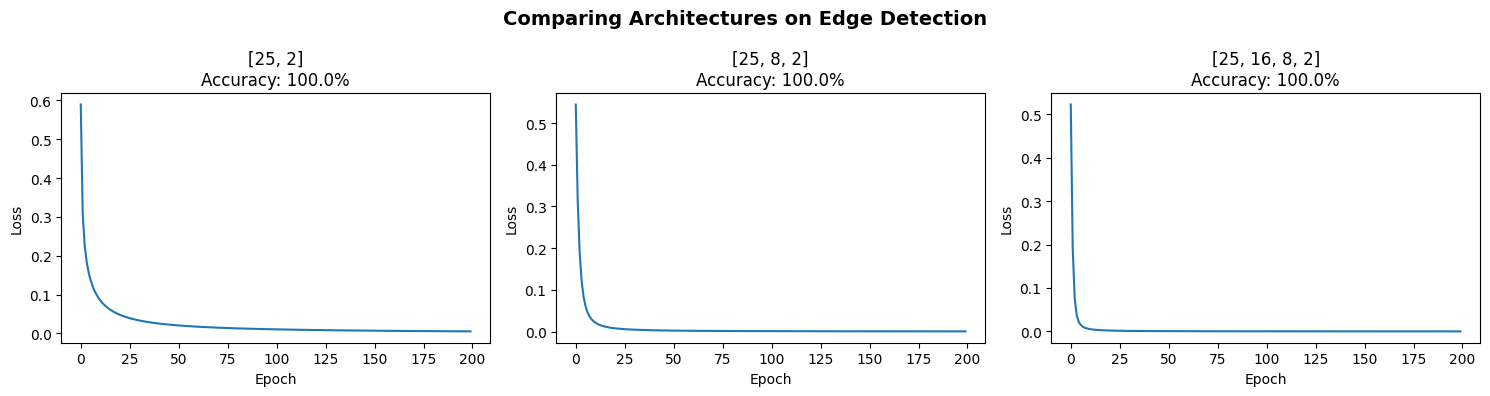

In [7]:
# Train with our flexible network!
# Try different architectures:

architectures = [
    [25, 2],           # No hidden layers (like logistic regression)
    [25, 8, 2],        # 1 hidden layer (like our original)
    [25, 16, 8, 2],    # 2 hidden layers
]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, arch in enumerate(architectures):
    np.random.seed(42)  # Same initialization for fair comparison
    
    net = Network(arch)
    losses = []
    
    # Training loop
    for epoch in range(200):
        # Mini-batch training
        epoch_loss = 0
        for i in range(0, len(X_train), 16):  # batch size 16
            batch_x = X_train[i:i+16]
            batch_y = y_train[i:i+16]
            loss = net.train_step(batch_x, batch_y, lr=0.1)
            epoch_loss += loss
        losses.append(epoch_loss / (len(X_train) / 16))
    
    # Evaluate
    z = net.forward(X_test)
    pred = np.argmax(z, axis=1)
    true = np.argmax(y_test, axis=1)
    accuracy = np.mean(pred == true) * 100
    
    # Plot
    axes[idx].plot(losses)
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Loss')
    axes[idx].set_title(f'{arch}\nAccuracy: {accuracy:.1f}%')

plt.suptitle('Comparing Architectures on Edge Detection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## The Power of Flexibility

Now changing architectures is trivial:

```python
# Shallow and wide
net = Network([784, 512, 10])

# Deep and narrow  
net = Network([784, 128, 64, 32, 10])

# Our edge detector
net = Network([25, 8, 2])
```

The same training code works for all of them!


---

## Complete Code

Here's the full implementation in ~100 lines:


In [8]:
"""
Flexible Neural Network from Scratch
=====================================
A minimal, clean implementation using only NumPy.
Supports arbitrary layer sizes like [784, 128, 64, 10].
"""

import numpy as np

# ============================================================
# LAYER CLASSES
# ============================================================

class Linear:
    """Fully connected layer: z = x @ W + b"""
    def __init__(self, in_features, out_features):
        self.W = np.random.randn(in_features, out_features) * np.sqrt(2.0 / in_features)
        self.b = np.zeros((1, out_features))
        self.x = None
        self.dW, self.db = None, None
    
    def forward(self, x):
        self.x = x
        return x @ self.W + self.b
    
    def backward(self, dz):
        self.dW = self.x.T @ dz
        self.db = np.sum(dz, axis=0, keepdims=True)
        return dz @ self.W.T
    
    def update(self, lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db


class ReLU:
    """ReLU activation: h = max(0, z)"""
    def __init__(self):
        self.z = None
    
    def forward(self, z):
        self.z = z
        return np.maximum(0, z)
    
    def backward(self, dh):
        return dh * (self.z > 0)
    
    def update(self, lr):
        pass


class SoftmaxCrossEntropy:
    """Combined softmax + cross-entropy loss"""
    def __init__(self):
        self.p, self.y = None, None
    
    def forward(self, z, y):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        self.p = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        self.y = y
        return -np.sum(y * np.log(self.p + 1e-8)) / len(y)
    
    def backward(self):
        return (self.p - self.y) / len(self.y)


# ============================================================
# NETWORK CLASS
# ============================================================

class Network:
    """A neural network as a stack of layers"""
    def __init__(self, layer_sizes):
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            self.layers.append(Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                self.layers.append(ReLU())
        self.loss_fn = SoftmaxCrossEntropy()
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self):
        grad = self.loss_fn.backward()
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)
    
    def train_step(self, x, y, lr):
        z = self.forward(x)
        loss = self.loss_fn.forward(z, y)
        self.backward()
        self.update(lr)
        return loss


# ============================================================
# USAGE EXAMPLE
# ============================================================

if __name__ == "__main__":
    # Create network with any architecture
    net = Network([25, 16, 8, 2])
    
    # Generate dummy data
    X = np.random.randn(100, 25)
    y = np.eye(2)[np.random.randint(0, 2, 100)]
    
    # Train
    for epoch in range(100):
        loss = net.train_step(X, y, lr=0.01)
        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss = {loss:.4f}")
    
    print("\nDone! Change [25, 16, 8, 2] to any architecture you want.")


Epoch 0: Loss = 0.8954
Epoch 20: Loss = 0.7847
Epoch 40: Loss = 0.7394
Epoch 60: Loss = 0.7117
Epoch 80: Loss = 0.6915

Done! Change [25, 16, 8, 2] to any architecture you want.


---

## Summary

**Key insights:**

1. **Layers are objects** — each stores its weights and handles forward/backward
2. **Forward pass is a loop** — pass data through each layer in order
3. **Backward pass is a reversed loop** — pass gradients through each layer in reverse
4. **Each layer caches what it needs** — the input (for computing weight gradients)

**The pattern for any layer:**
```python
def forward(self, x):
    self.cache = x          # Store what we need for backward
    return f(x)             # Compute output

def backward(self, grad_output):
    grad_weights = ...      # Use cache to compute weight gradients
    grad_input = ...        # Compute gradient for layer below
    return grad_input
```

**What we gained:**
- Change architecture with one line: `Network([784, 256, 128, 64, 10])`
- Same training code works for any depth
- Easy to add new layer types (Dropout, BatchNorm, etc.)

---

**Further Reading:**
- [Understanding Neural Networks: From Pixels to Predictions](nn_tutorial_blog.ipynb) — The concepts behind this code
- [PyTorch nn.Module](https://pytorch.org/docs/stable/nn.html) — How the pros do it (same pattern!)
